<a href="https://colab.research.google.com/github/open-mmlab/mmsegmentation/blob/master/demo/MMSegmentation_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Train a semantic segmentation model on a new dataset

To train on a customized dataset, the following steps are neccessary. 
1. Add a new dataset class. 
2. Create a config file accordingly. 
3. Perform training and evaluation. 

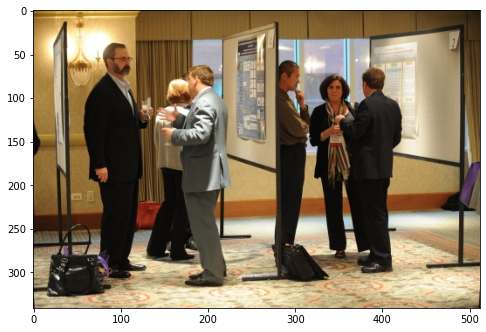

In [1]:
# Let's take a look at the dataset
import glob
import mmcv
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import os.path as osp
import numpy as np
from PIL import Image

data_root = '/data/modanet_cnvrg-1'
ann_dir = 'masks'
img_dir = 'images'

img_file = glob.glob(osp.join(data_root, img_dir, "*jpg"))[0]
img = mmcv.imread(img_file)
plt.figure(figsize=(8, 6))
plt.imshow(mmcv.bgr2rgb(img))
plt.show()

We need to convert the annotation into semantic map format as an image.

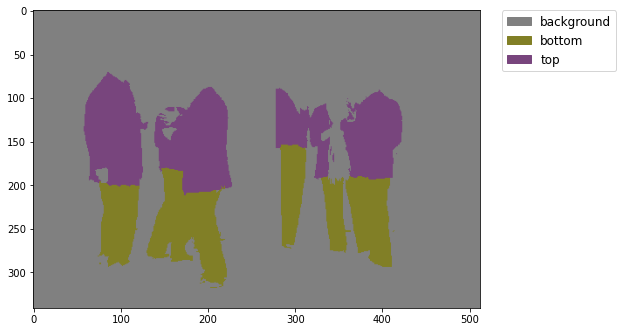

In [2]:
# Let's take a look at the segmentation map we got

classes = ('background', 'bottom', 'top')
palette = [[128, 128, 128], [129, 127, 38], [120, 69, 125]]

img = Image.open(osp.join(data_root, ann_dir, osp.basename(img_file).replace(".jpg", ".png")))
img = np.array(img.convert('RGB'))
for i in range(len(classes)):
    img[img[:,:,0]==i] = palette[i]
plt.figure(figsize=(8, 6))
im = plt.imshow(img)


# create a patch (proxy artist) for every color 
patches = [mpatches.Patch(color=np.array(palette[i])/255., 
                          label=classes[i]) for i in range(3)]
# put those patched as legend-handles into the legend
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., 
           fontsize='large')

plt.show()

In [3]:
# split train/val set randomly
split_dir = 'splits'
mmcv.mkdir_or_exist(osp.join(data_root, split_dir))
filename_list = [osp.splitext(filename)[0] for filename in mmcv.scandir(
    osp.join(data_root, ann_dir), suffix='.png')]
with open(osp.join(data_root, split_dir, 'train.txt'), 'w') as f:
  # select first 4/5 as train set
  train_length = int(len(filename_list)*4/5)
  f.writelines(line + '\n' for line in filename_list[:train_length])
with open(osp.join(data_root, split_dir, 'val.txt'), 'w') as f:
  # select last 1/5 as train set
  f.writelines(line + '\n' for line in filename_list[train_length:])

Creating a new dataset class `ClothesDataset`.

In [16]:
from mmseg.datasets.builder import DATASETS
from mmseg.datasets.custom import CustomDataset

@DATASETS.register_module()
class ClothesDataset(CustomDataset):
  CLASSES = classes
  PALETTE = palette
  def __init__(self, split, **kwargs):
    super().__init__(img_suffix='.jpg', seg_map_suffix='.png', 
                     split=split, **kwargs)
    assert osp.exists(self.img_dir) and self.split is not None

    

### Create a config file
In the next step, we need to modify the config for the training. To accelerate the process, we finetune the model from trained weights.

In [18]:
from mmcv import Config
cfg = Config.fromfile('/cnvrg/configs/ocrnet/ocrnet_hr48_512x512_20k_voc12aug.py')

Since the given config is used to train PSPNet on cityscapes dataset, we need to modify it accordingly for our new dataset.  

In [19]:
from mmseg.apis import set_random_seed

# Since we use ony one GPU, BN is used instead of SyncBN
cfg.norm_cfg = dict(type='BN', requires_grad=True)
cfg.model.backbone.norm_cfg = cfg.norm_cfg
for head in cfg.model.decode_head:
    head.norm_cfg = cfg.norm_cfg
    # modify num classes of the model in decode/auxiliary head
    head.num_classes = 3

# Modify dataset type and path
cfg.dataset_type = 'ClothesDataset'
cfg.data_root = data_root

cfg.data.samples_per_gpu = 4
cfg.data.workers_per_gpu = 4

cfg.img_norm_cfg = dict(
    mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375], to_rgb=True)
cfg.crop_size = (512, 512)
cfg.train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations'),
    dict(type='Resize', img_scale=(512, 1024), ratio_range=(0.5, 2.0)),
    dict(type='RandomCrop', crop_size=cfg.crop_size, cat_max_ratio=0.75),
    dict(type='RandomFlip', flip_ratio=0.5),
    dict(type='PhotoMetricDistortion'),
    dict(type='Normalize', **cfg.img_norm_cfg),
    dict(type='Pad', size=cfg.crop_size, pad_val=0, seg_pad_val=255),
    dict(type='DefaultFormatBundle'),
    dict(type='Collect', keys=['img', 'gt_semantic_seg']),
]

cfg.test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(
        type='MultiScaleFlipAug',
        img_scale=(512, 1024),
        # img_ratios=[0.5, 0.75, 1.0, 1.25, 1.5, 1.75],
        flip=False,
        transforms=[
            dict(type='Resize', keep_ratio=True),
            dict(type='RandomFlip'),
            dict(type='Normalize', **cfg.img_norm_cfg),
            dict(type='ImageToTensor', keys=['img']),
            dict(type='Collect', keys=['img']),
        ])
]


cfg.data.train.type = cfg.dataset_type
cfg.data.train.data_root = cfg.data_root
cfg.data.train.img_dir = img_dir
cfg.data.train.ann_dir = ann_dir
cfg.data.train.pipeline = cfg.train_pipeline
cfg.data.train.split = 'splits/train.txt'

cfg.data.val.type = cfg.dataset_type
cfg.data.val.data_root = cfg.data_root
cfg.data.val.img_dir = img_dir
cfg.data.val.ann_dir = ann_dir
cfg.data.val.pipeline = cfg.test_pipeline
cfg.data.val.split = 'splits/val.txt'

cfg.data.test.type = cfg.dataset_type
cfg.data.test.data_root = cfg.data_root
cfg.data.test.img_dir = img_dir
cfg.data.test.ann_dir = ann_dir
cfg.data.test.pipeline = cfg.test_pipeline
cfg.data.test.split = 'splits/val.txt'

# We can still use the pre-trained Mask RCNN model though we do not need to
# use the mask branch
cfg.load_from = '/cnvrg/checkpoints/ocrnet_hr48_512x512_20k_voc12aug_20200617_233932-9e82080a.pth'

# Set up working dir to save files and logs.
cfg.work_dir = '/cnvrg/output/ocrnet_hr48_512x512_20k_voc12aug'

cfg.total_iters = 200
cfg.log_config.interval = 10
cfg.evaluation.interval = 200
cfg.checkpoint_config.interval = 200

# Set seed to facitate reproducing the result
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)

# Let's have a look at the final config used for training
print(f'Config:\n{cfg.pretty_text}')

ImportError: libcudart.so.10.1: cannot open shared object file: No such file or directory

### Train and Evaluation

In [19]:
from mmseg.datasets import build_dataset
from mmseg.models import build_segmentor
from mmseg.apis import train_segmentor


# Build the dataset
datasets = [build_dataset(cfg.data.train)]

# Build the detector
model = build_segmentor(
    cfg.model, train_cfg=cfg.train_cfg, test_cfg=cfg.test_cfg)
# Add an attribute for visualization convenience
model.CLASSES = datasets[0].CLASSES

# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_segmentor(model, datasets, cfg, distributed=False, validate=True, 
                meta=dict())

2020-07-09 19:14:27,264 - mmseg - INFO - Loaded 572 images
Downloading: "https://open-mmlab.s3.ap-northeast-2.amazonaws.com/pretrain/third_party/resnet50_v1c-2cccc1ad.pth" to /root/.cache/torch/checkpoints/resnet50_v1c-2cccc1ad.pth


2020-07-09 19:14:39,770 - mmseg - WARNING - The model and loaded state dict do not match exactly

unexpected key in source state_dict: fc.weight, fc.bias

2020-07-09 19:14:39,836 - mmseg - INFO - Loaded 143 images
2020-07-09 19:14:39,837 - mmseg - INFO - load checkpoint from checkpoints/pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth


2020-07-09 19:14:39,990 - mmseg - WARNING - The model and loaded state dict do not match exactly

size mismatch for decode_head.conv_seg.weight: copying a param with shape torch.Size([19, 512, 1, 1]) from checkpoint, the shape in current model is torch.Size([8, 512, 1, 1]).
size mismatch for decode_head.conv_seg.bias: copying a param with shape torch.Size([19]) from checkpoint, the shape in current model is torch.Size([8]).
size mismatch for auxiliary_head.conv_seg.weight: copying a param with shape torch.Size([19, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([8, 256, 1, 1]).
size mismatch for auxiliary_head.conv_seg.bias: copying a param with shape torch.Size([19]) from checkpoint, the shape in current model is torch.Size([8]).
2020-07-09 19:14:39,994 - mmseg - INFO - Start running, host: root@71c6cf9b06c5, work_dir: /content/mmsegmentation/work_dirs/tutorial
2020-07-09 19:14:39,995 - mmseg - INFO - workflow: [('train', 1)], max: 200 iters
2020-07-09 19:14:54,

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 143/143, 10.9 task/s, elapsed: 13s, ETA:     0s

2020-07-09 19:19:22,647 - mmseg - INFO - per class results:
Class                  IoU        Acc
sky                  88.67      94.28
tree                 68.95      86.73
road                 86.23      94.42
grass                70.01      91.35
water                62.08      68.32
bldg                 81.11      88.89
mntn                  0.00       0.00
fg obj               70.39      82.49
Summary:
Scope                 mIoU       mAcc       aAcc
global               65.93      75.81      87.48

2020-07-09 19:19:22,660 - mmseg - INFO - Iter [200/200]	lr: 1.841e-04, mIoU: 0.6593, mAcc: 0.7581, aAcc: 0.8748


Inference with trained model

/content/mmsegmentation/mmseg/models/segmentors/base.py:265: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


<Figure size 576x432 with 0 Axes>

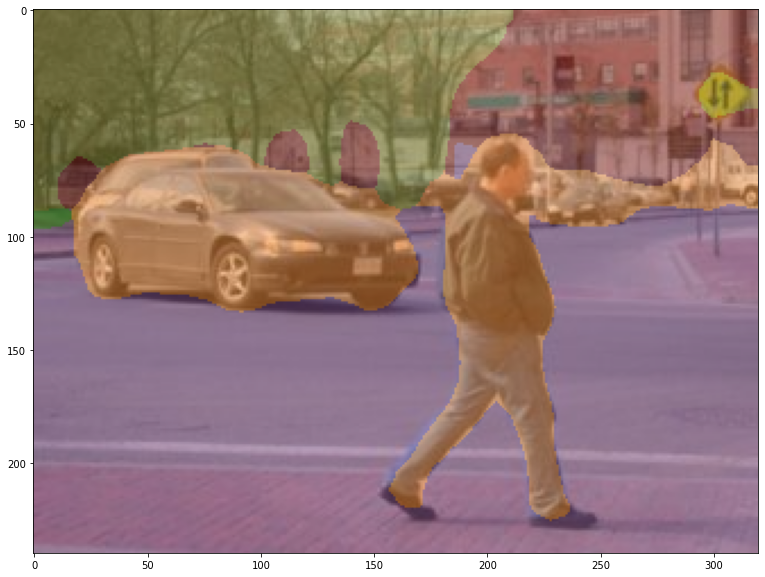

In [20]:
from mmseg.apis import inference_segmentor

img = mmcv.imread(osp.join(data_root, img_dir, '1004.jpg'))

model.cfg = cfg
result = inference_segmentor(model, img)
plt.figure(figsize=(8, 6))
show_result_pyplot(model, img, result, palette)